In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from resnet1d import Res34SimSiam, Res34SimSiamSplitHeads, Resnet34, Resnet34Baseline, ResBlock
from dataset import Dataset_per_file, Dataset_whole, Dataset_ori
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
import os
import numpy as np
from tqdm import tqdm
import argparse
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import sys
import os
import matplotlib.pyplot as plt
import gc

from collections import OrderedDict

import pacmap
from annoy import AnnoyIndex

In [2]:
val_dataset = Dataset_whole('/labs/hulab/stark_stuff/ppg_ecg_project/data/', split='val', subset=0)

	loading... val
	AF loaded val
	PVC loaded val
	NSR loaded val
	loading val finished t=0:01:14.291125, mem used=65.906589696
dataset built AF counts 1280775, NSR counts 1505119, total counts 2785894


In [3]:
# val_subset_dataset = Dataset_whole('/labs/hulab/stark_stuff/ppg_ecg_project/data/', split='val', subset=0)
np.random.seed(1)
subset_idx = np.random.choice(np.arange(len(val_dataset)), replace=False, size=int(len(val_dataset)*0.01))
val_subset_dataset = Subset(val_dataset, subset_idx)
print(len(val_subset_dataset))
# del val_dataset
# gc.collect()

27858


In [4]:
val_loader = DataLoader(val_subset_dataset, batch_size=2500, shuffle=False, num_workers=0)

In [5]:
def get_activations(dataloader, model, modules, MODEL_PATH, source='PPG', reparse_state_dict=True):
    state_dict = torch.load(MODEL_PATH) 

    if reparse_state_dict:
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] #remove 'module'
            new_state_dict[name] = v

        state_dict = new_state_dict
    model.load_state_dict(state_dict)
    
    activations = {}
    hooks = {}

    def get_activation(name):

        def hook(model, input, output):
            if not name in activations.keys():
                activations[name] = output.detach().cpu().numpy()
            else:
                activations[name] = np.concatenate((activations[name], output.detach().cpu().numpy()), axis=0)

        return hook
    
    for module in modules:
        for name, layer in module.named_children():
            if 'pool' in name:
                hooks[name] = layer.register_forward_hook(get_activation(name))
    
    labels = None
    
    for batch_idx, (ECG, PPG, target) in enumerate(tqdm(dataloader)):

        PPG = PPG.cuda().float()
        ECG = ECG.cuda().float()
        
        if batch_idx == 0:
            labels = target.cpu().numpy()
        else:
            labels = np.concatenate((labels, target.cpu().numpy()))
        
        if source == 'PPG': 
            model(PPG, PPG)
        else:
            model(ECG, ECG)
    for h in hooks.values(): h.remove()
        
    del model, state_dict, hooks
    gc.collect()
        
    return activations, labels

# SimSiam

In [6]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128/model_1.pt'

In [7]:
model = Res34SimSiam(512, 128, single_source_mode=True).cuda()

In [8]:
PPG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='PPG')
ECG_activations, labels = get_activations(val_loader, model, [model.encoder], MODEL_PATH, source='ECG')

100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


In [9]:
for key, value in PPG_activations.items():
    print(key, value.shape)

pool0 (27858, 48, 145)
pool1 (27858, 48, 36)
pool2 (27858, 96, 9)
pool3 (27858, 192, 2)
avgpool (27858, 384, 2)


In [10]:
for key, value in ECG_activations.items():
    print(key, value.shape)

pool0 (27858, 48, 145)
pool1 (27858, 48, 36)
pool2 (27858, 96, 9)
pool3 (27858, 192, 2)
avgpool (27858, 384, 2)


In [11]:
for key in PPG_activations.keys():
    activation = np.concatenate((PPG_activations[key], ECG_activations[key]), axis=0)
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(55716, 6960)
pool0 (55716, 2)
(55716, 1728)
pool1 (55716, 2)
(55716, 864)
pool2 (55716, 2)
(55716, 384)
pool3 (55716, 2)
(55716, 768)
avgpool (55716, 2)


pool0 (55716, 2)


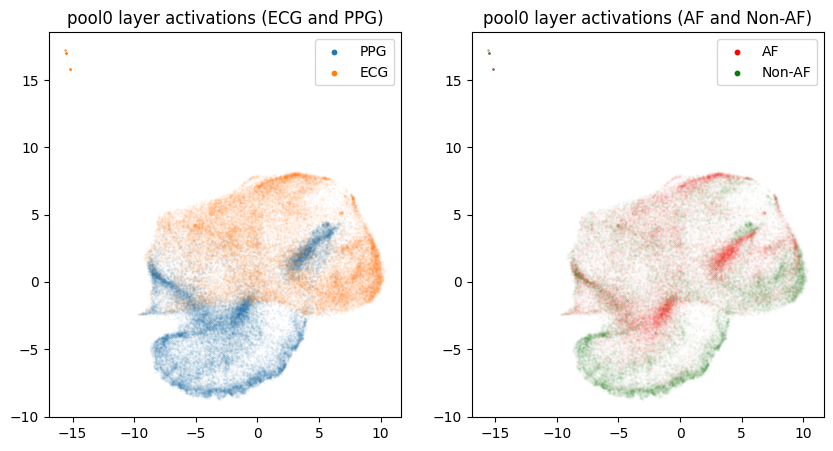

pool1 (55716, 2)


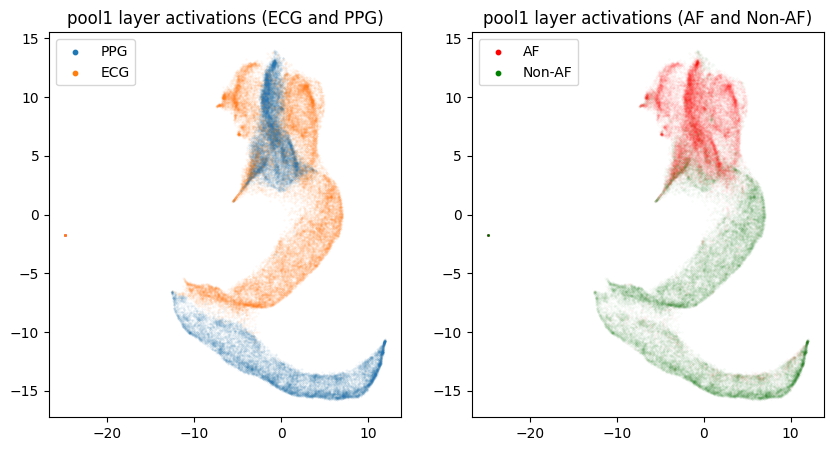

pool2 (55716, 2)


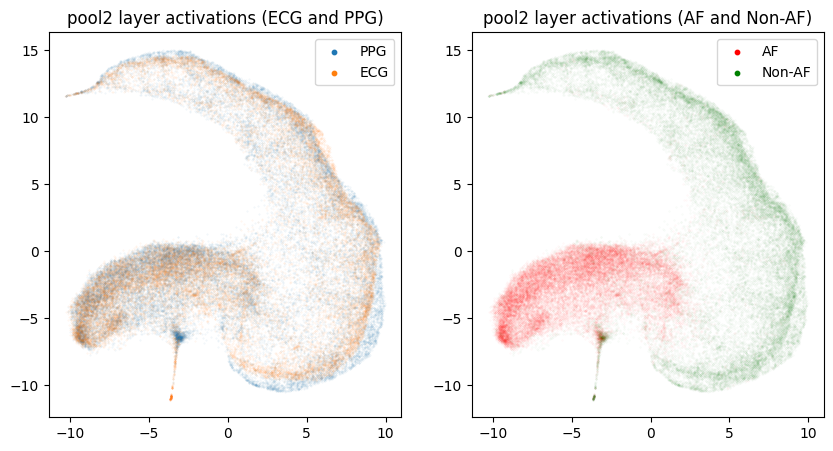

pool3 (55716, 2)


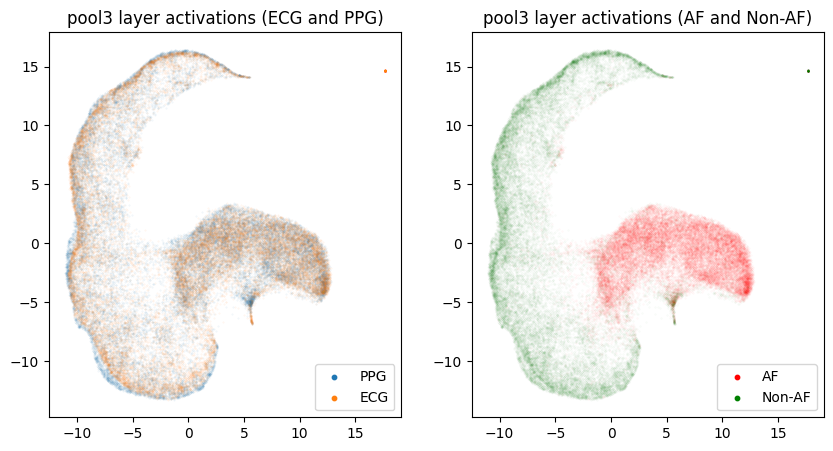

avgpool (55716, 2)


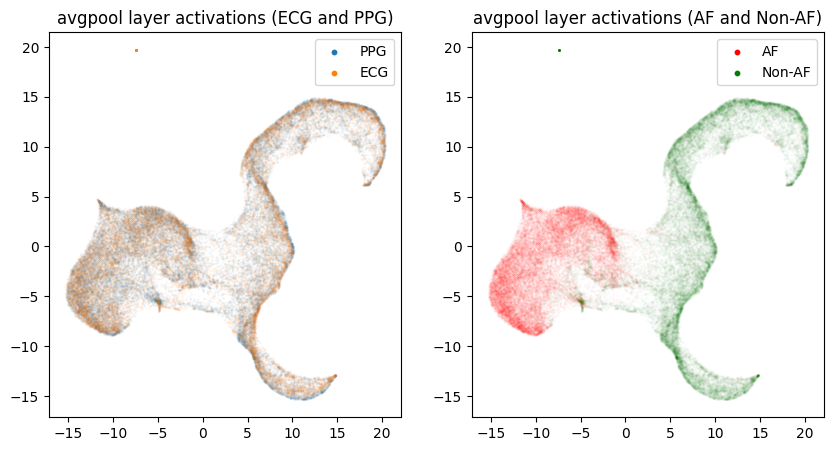

In [13]:
for key in PPG_activations.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}.npy')
    print(key, X_transformed.shape)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='ECG')
    leg0 = ax0.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
#     print(X_transformed[:, 0][:labels.shape[0]][labels==1].shape, labels.shape, sum(labels==1))
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==1], X_transformed[:, 1][labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==0], X_transformed[:, 1][labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color='g')

    leg1 = ax1.legend(numpoints=10)
    for lh in leg1.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    ax0.set_title(f'{key} layer activations (ECG and PPG)')
    ax1.set_title(f'{key} layer activations (AF and Non-AF)')
    plt.show()

# Simsiam no predictor

In [14]:
MODEL_PATH_nopredictor = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128_pred_False_no_predictor/model_1.pt'

In [15]:
model_nopredictor = Res34SimSiam(512, 128, predictor=False, single_source_mode=True).cuda()

In [16]:
PPG_activations_nopredictor, labels = get_activations(val_loader, model_nopredictor, [model_nopredictor.encoder], MODEL_PATH_nopredictor, source='PPG')
ECG_activations_nopredictor, labels = get_activations(val_loader, model_nopredictor, [model_nopredictor.encoder],MODEL_PATH_nopredictor, source='ECG')

100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


In [17]:
for key in PPG_activations_nopredictor.keys():
    activation = np.concatenate((PPG_activations_nopredictor[key], ECG_activations_nopredictor[key]), axis=0)
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_nopredictor.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(55716, 6960)
pool0 (55716, 2)
(55716, 1728)
pool1 (55716, 2)
(55716, 864)
pool2 (55716, 2)
(55716, 384)
pool3 (55716, 2)
(55716, 768)
avgpool (55716, 2)


pool0 (55716, 2)


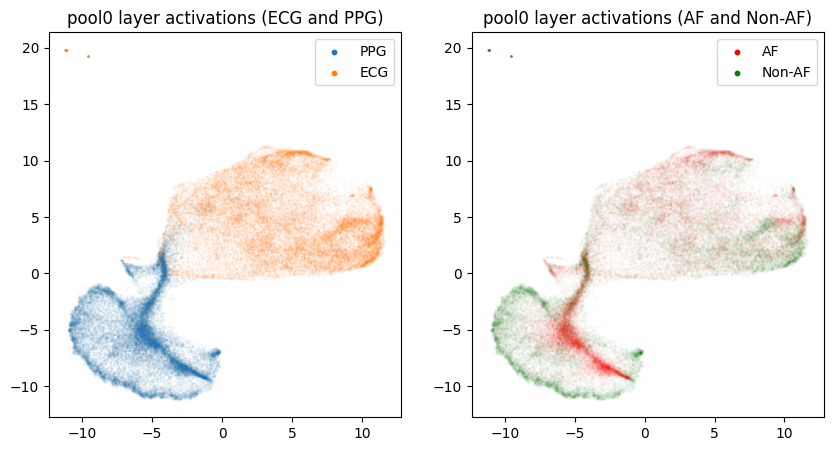

pool1 (55716, 2)


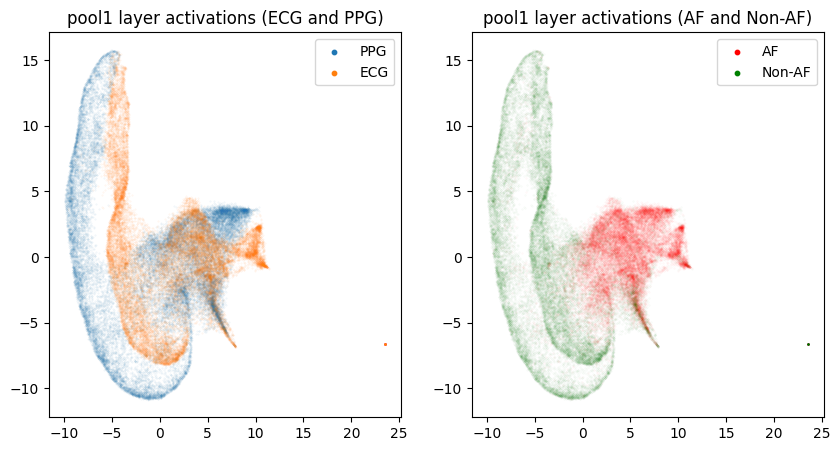

pool2 (55716, 2)


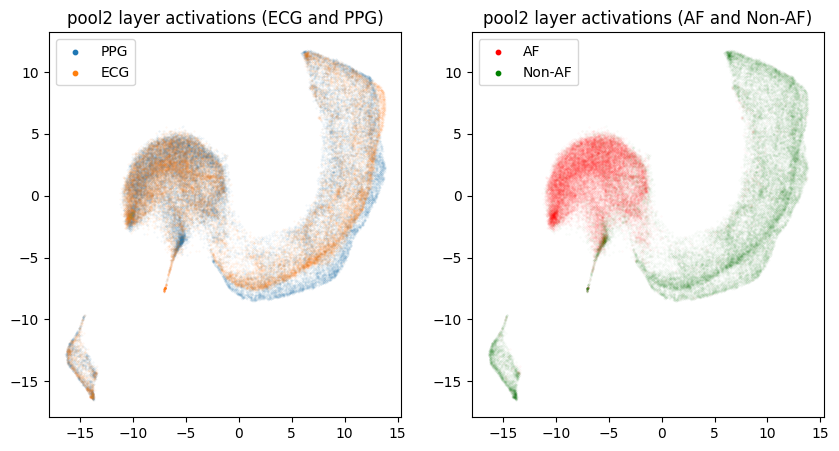

pool3 (55716, 2)


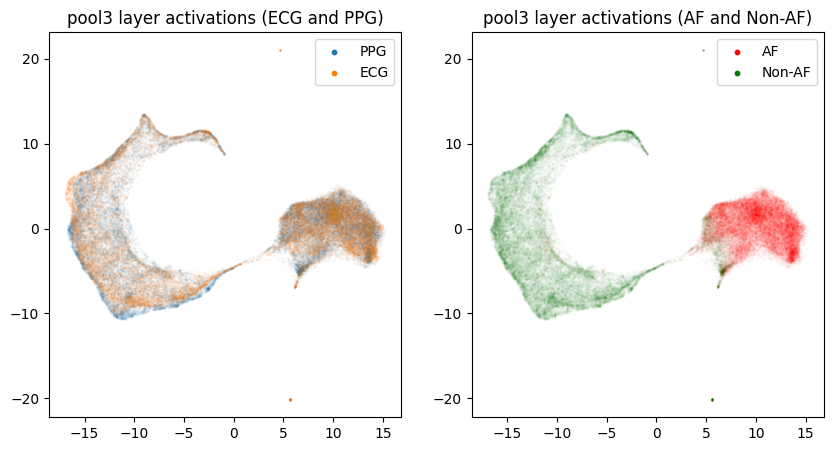

avgpool (55716, 2)


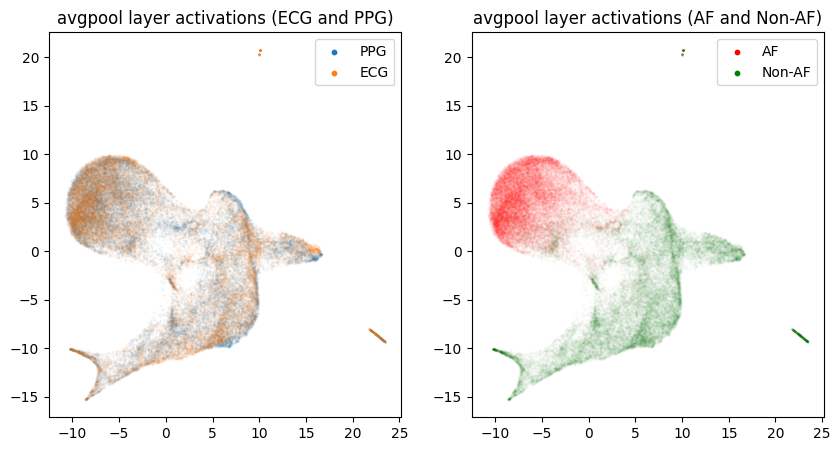

In [18]:
for key in PPG_activations_nopredictor.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_nopredictor.npy')
    print(key, X_transformed.shape)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='ECG')
    leg0 = ax0.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
#     print(X_transformed[:, 0][:labels.shape[0]][labels==1].shape, labels.shape, sum(labels==1))
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==1], X_transformed[:, 1][labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==0], X_transformed[:, 1][labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color='g')

    leg1 = ax1.legend(numpoints=10)
    for lh in leg1.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    ax0.set_title(f'{key} layer activations (ECG and PPG)')
    ax1.set_title(f'{key} layer activations (AF and Non-AF)')
    plt.show()

# Simsiam split heads

In [19]:
MODEL_PATH_splitheads = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/epoch_40_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128_pred_True_splitheads/model_1.pt'

In [20]:
model_splitheads_PPG = Res34SimSiamSplitHeads(512, 128, single_source_mode=True, single_source_head='PPG').cuda()
model_splitheads_ECG = Res34SimSiamSplitHeads(512, 128, single_source_mode=True, single_source_head='ECG').cuda()

In [21]:
PPG_activations_splitheads, labels = get_activations(val_loader, model_splitheads_PPG, [model_splitheads_PPG.PPG_head, model_splitheads_PPG.encoder], MODEL_PATH_splitheads, source='PPG')
ECG_activations_splitheads, labels = get_activations(val_loader, model_splitheads_ECG, [model_splitheads_ECG.ECG_head, model_splitheads_ECG.encoder], MODEL_PATH_splitheads, source='ECG')

100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


In [22]:
for key in PPG_activations_splitheads.keys():
    activation = np.concatenate((PPG_activations_splitheads[key], ECG_activations_splitheads[key]), axis=0)
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_splitheads.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break

(55716, 6960)
pool0 (55716, 2)
(55716, 1728)
pool1 (55716, 2)
(55716, 864)
pool2 (55716, 2)
(55716, 384)
pool3 (55716, 2)
(55716, 768)
avgpool (55716, 2)


pool0 (55716, 2)


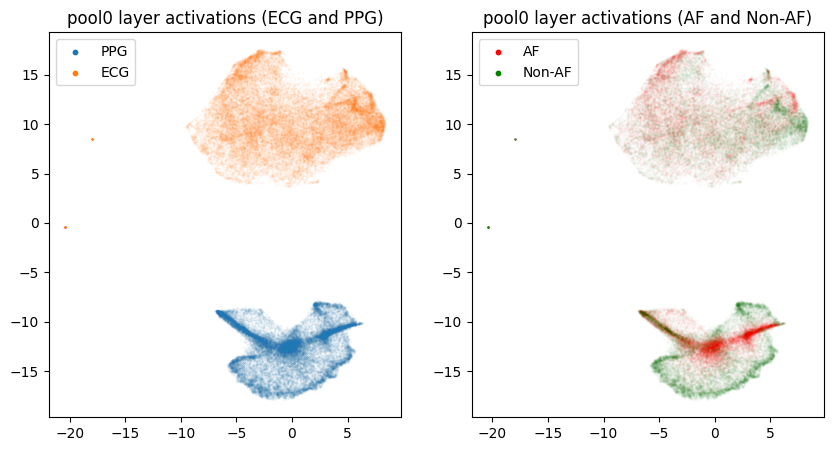

pool1 (55716, 2)


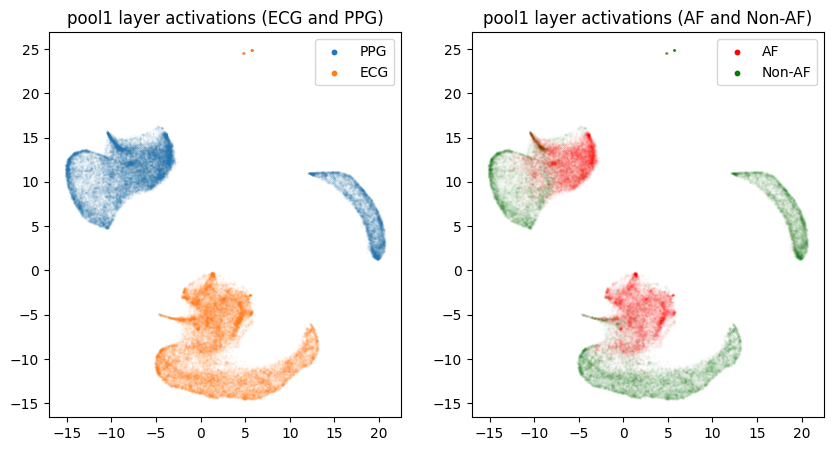

pool2 (55716, 2)


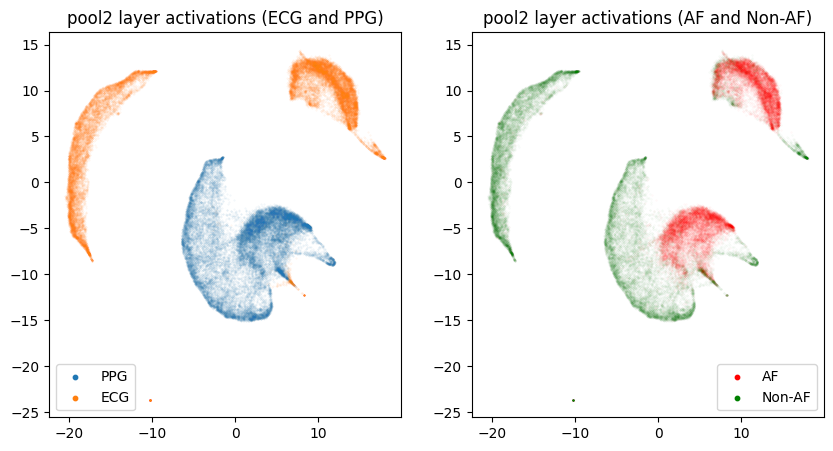

pool3 (55716, 2)


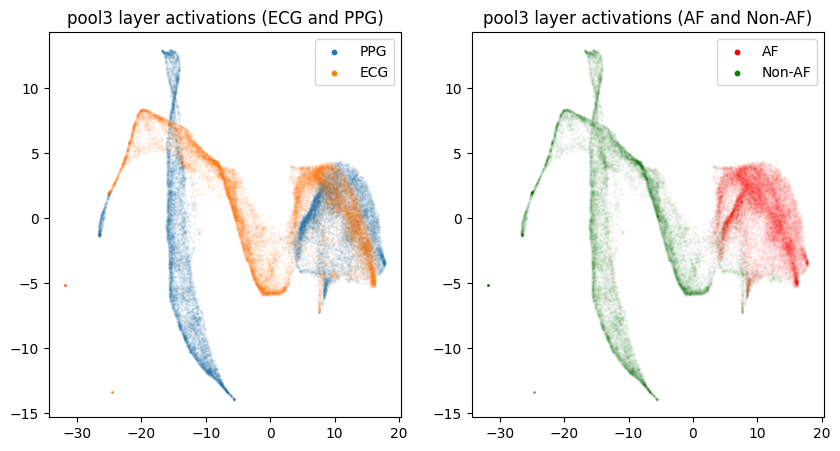

avgpool (55716, 2)


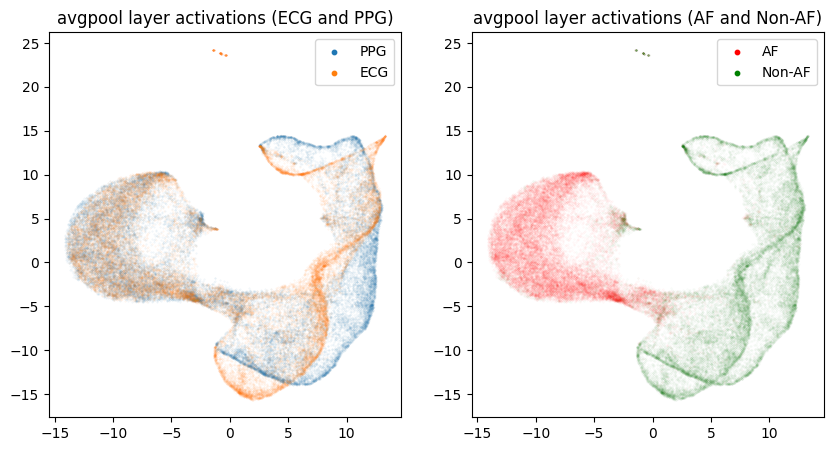

In [23]:
for key in PPG_activations_splitheads.keys():
    X_transformed = np.load(f'val_latent_activation_npys/activaton_transformed_{key}_splitheads.npy')
    print(key, X_transformed.shape)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.scatter(X_transformed[:, 0][:labels.shape[0]], X_transformed[:, 1][:labels.shape[0]], alpha=0.1, s=0.1, label='PPG')
    ax0.scatter(X_transformed[:, 0][labels.shape[0]:], X_transformed[:, 1][labels.shape[0]:], alpha=0.1, s=0.1, label='ECG')
    leg0 = ax0.legend(numpoints=10)
    for lh in leg0.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
#     print(X_transformed[:, 0][:labels.shape[0]][labels==1].shape, labels.shape, sum(labels==1))
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==1], X_transformed[:, 1][:labels.shape[0]][labels==1], alpha=0.05, s=0.1, label='AF', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==1], X_transformed[:, 1][labels.shape[0]:][labels==1], alpha=0.05, s=0.1, label='', color='r')
    ax1.scatter(X_transformed[:, 0][labels.shape[0]:][labels==0], X_transformed[:, 1][labels.shape[0]:][labels==0], alpha=0.05, s=0.1, label='Non-AF', color='g')
    ax1.scatter(X_transformed[:, 0][:labels.shape[0]][labels==0], X_transformed[:, 1][:labels.shape[0]][labels==0], alpha=0.05, s=0.1, label='', color='g')

    leg1 = ax1.legend(numpoints=10)
    for lh in leg1.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [10]
        
    ax0.set_title(f'{key} layer activations (ECG and PPG)')
    ax1.set_title(f'{key} layer activations (AF and Non-AF)')
    plt.show()

# Baseline

In [6]:
MODEL_PATH_baseline = '/home/zguo30/ppg_ecg_proj/ppg_only_baseline/saved_models/epoch_40_ppglr_0.0001_lambda_0.9/PPG_best_2.pt'
model = Resnet34Baseline().cuda()

In [7]:
PPG_baseline_activations, labels = get_activations(val_loader, model, [model], MODEL_PATH_baseline, source='PPG', reparse_state_dict=False)

100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


In [8]:
for key, value in PPG_baseline_activations.items():
    print(key, value.shape)

pool0 (27858, 48, 145)
pool1 (27858, 48, 36)
pool2 (27858, 96, 9)
pool3 (27858, 192, 2)
avgpool (27858, 384, 2)


In [ ]:
for key in PPG_baseline_activations.keys():
    activation = np.concatenate((PPG_baseline_activations[key], ECG_activations[key]), axis=0)
    activation = activation.reshape(activation.shape[0], -1)
    print(activation.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(activation, init="pca")
    np.save(f'val_latent_activation_npys/activaton_transformed_{key}_baseline.npy', X_transformed)
    
    print(key, X_transformed.shape)
    
#     break